In [1]:
import random
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')


KeyboardInterrupt: 

In [ ]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

if torch.cuda.is_available(): device = torch.device("cuda")
elif torch.backends.mps.is_available(): device = torch.device("mps")
else: device = torch.device('cpu')
# device = torch.device('cpu')

In [ ]:
# input_window, output_window, batch_size, epochs, feature_size, d_ff, num_layers, lr, dropout
params = [120, 1, 32, 300, 32, 512, 2, 1e-5, 0.1]

In [ ]:
DATA_TYPE = ""

In [ ]:
if DATA_TYPE == 'PMJ_':
    from transformer_type.model import TransAm
    from transformer_type.dataset import get_data

    DATA_PATH = "./data/kaggle_data/daily_data/"
    MODEL_PATH = r"C:\Users\qja19\Desktop\탄소\machine_learning\transformer_results\type_120-60_32_32-512-2_1e-05_100_0.1\models"
    type_list = ['AEP', 'COMED', 'DAYTON', 'DOM', 'DUQ', 'FE', 'NI', 'PJME', 'PJMW']

    def data_extract(df_dict, df, name, cols):
        for col in cols:
                df_dict[f"{name}_{col}"] = df.loc[df[col] != 0, col]
        return df_dict

    train_data_list = []
    val_data_list = []

    pmj_df = pd.read_csv(DATA_PATH + "pjm_elec_daily.csv")
    pmj_cols = ['AEP', 'COMED', 'DAYTON', 'DOM', 'DUQ', 'FE', 'NI', 'PJME', 'PJMW'] # 'DEOK', 'EKPC', 'PJM_Load'

    df_dict = {}

    df_dict = data_extract(df_dict, pmj_df, 'PMJ', pmj_cols)

    for df_name in df_dict:
        df = df_dict[df_name]
        train_data, val_data, scaler = get_data(df, params[0], params[1])
        train_data = train_data.to(device)
        val_data = val_data.to(device)
        print(df_name, len(train_data), len(val_data))
        train_data_list.append((train_data, df_name, scaler))
        val_data_list.append((val_data, df_name, scaler))

else:
    from transformer_multistep import TransAm, get_data

    DATA_PATH = "./data/korea/kor_gas_day.csv"
    MODEL_PATH = r"C:\Users\qja19\Desktop\탄소\machine_learning\transformer_results\single_model\120-1_64_32-2_1e-05_100\120_64_32-2_1e-05_100.pt"
    type_list = ['A', 'B', 'C', 'D', 'E', 'G', 'H']

    train_data1, val_data1, scaler1 = get_data('A')
    train_data2, val_data2, scaler2 = get_data('B')
    train_data3, val_data3, scaler3 = get_data('C')
    train_data4, val_data4, scaler4 = get_data('D')
    train_data5, val_data5, scaler5 = get_data('E')
    train_data6, val_data6, scaler6 = get_data('G')
    train_data7, val_data7, scaler7 = get_data('H')

    train_data_list = ((train_data1, 'A', scaler1),
                    (train_data2, 'B', scaler2),
                    (train_data3, 'C', scaler3),
                    (train_data4, 'D', scaler4),
                    (train_data5, 'E', scaler5),
                    (train_data6, 'G', scaler6),
                    (train_data7, 'H', scaler7)
                    )

    val_data_list = ((val_data1, 'A', scaler1),
                    (val_data2, 'B', scaler2),
                    (val_data3, 'C', scaler3),
                    (val_data4, 'D', scaler4),
                    (val_data5, 'E', scaler5),
                    (val_data6, 'G', scaler6),
                    (val_data7, 'H', scaler7)
                    )

PMJ_AEP 3922 889
PMJ_COMED 2095 433
PMJ_DAYTON 3922 889
PMJ_DOM 3752 847
PMJ_DUQ 3848 871
PMJ_FE 1974 403
PMJ_NI 1827 366
PMJ_PJME 4725 1090
PMJ_PJMW 4653 1072


In [ ]:
pred_seq = 60
if DATA_TYPE == 'PMJ_':
    models = {'PMJ_' + t : TransAm(32, 2, 512, 0.1) for t in type_list}
    for t in type_list:
        models['PMJ_' + t].load_state_dict(torch.load(MODEL_PATH + f"\\PMJ_{t}.pt"))
        models['PMJ_' + t].to(device)
else:
    model = TransAm(32, 2, 0.1)
    model.load_state_dict(torch.load(MODEL_PATH))
    model.to(device)
cur_values = {}
predictions = {}
true_values = {}
input_window, output_window = params[:2]

for val_data, t, scaler in val_data_list:
    if DATA_TYPE == 'PMJ_':
        model = models[t]
    model.eval()
    cur_values[t] = []
    predictions[t] = []
    true_values[t] = []
    for i in tqdm(range(params[0], len(val_data) - pred_seq)):
        data = val_data[i][0][:-1].reshape(-1, 1, 1)
        data.to(device)
        cur_values[t].append(float(scaler.inverse_transform(val_data[i][1][-1].cpu().detach().reshape(1, -1))))
        for _ in range(pred_seq):
            input = torch.clone(data[-input_window:])
            input[-output_window:] = 0     
            output = model(data[-input_window:])                   
            data = torch.cat((data, output[-1:]))
        predictions[t].append(float(scaler.inverse_transform(output[-1:].cpu().detach().reshape(1, -1))))
        true_values[t].append(float(scaler.inverse_transform(val_data[i + pred_seq][1][-1].cpu().detach().reshape(1, -1))))

100%|██████████| 892/892 [01:43<00:00,  8.62it/s]


AEP
mse:4576780800.0, mae:54748.98046875, smape:0.15271034836769104 (cur)
mse:1628685824.0, mae:32635.21484375, smape:0.09164910763502121 (pred)
COMED
mse:3161641984.0, mae:44239.96484375, smape:0.16235867142677307 (cur)
mse:1520997248.0, mae:28340.3125, smape:0.10197295993566513 (pred)
DAYTON
mse:108131256.0, mae:8417.6162109375, smape:0.17352323234081268 (cur)
mse:40191340.0, mae:5192.5458984375, smape:0.10786403715610504 (pred)
DOM
mse:4890011648.0, mae:54967.8203125, smape:0.19969207048416138 (cur)
mse:1677577984.0, mae:30324.734375, smape:0.11091293394565582 (pred)
DUQ
mse:58090976.0, mae:5939.7451171875, smape:0.15445350110530853 (cur)
mse:31640192.0, mae:4920.9267578125, smape:0.12873871624469757 (pred)
FE
mse:1142259456.0, mae:27160.51171875, smape:0.1440250277519226 (cur)
mse:464005120.0, mae:17360.134765625, smape:0.09139089286327362 (pred)
NI
mse:7861964288.0, mae:74304.9921875, smape:0.24712219834327698 (cur)
mse:3121540864.0, mae:43241.3515625, smape:0.1454334408044815 (pr

<Figure size 1000x1000 with 0 Axes>

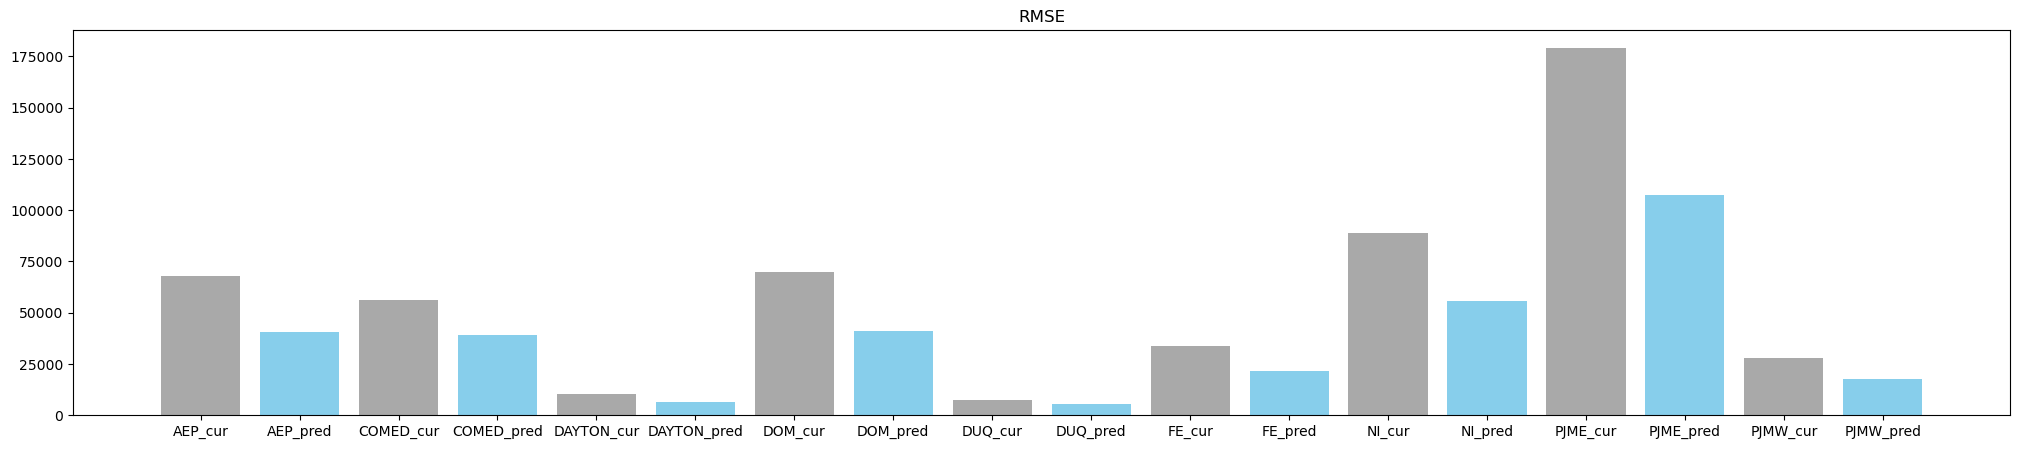

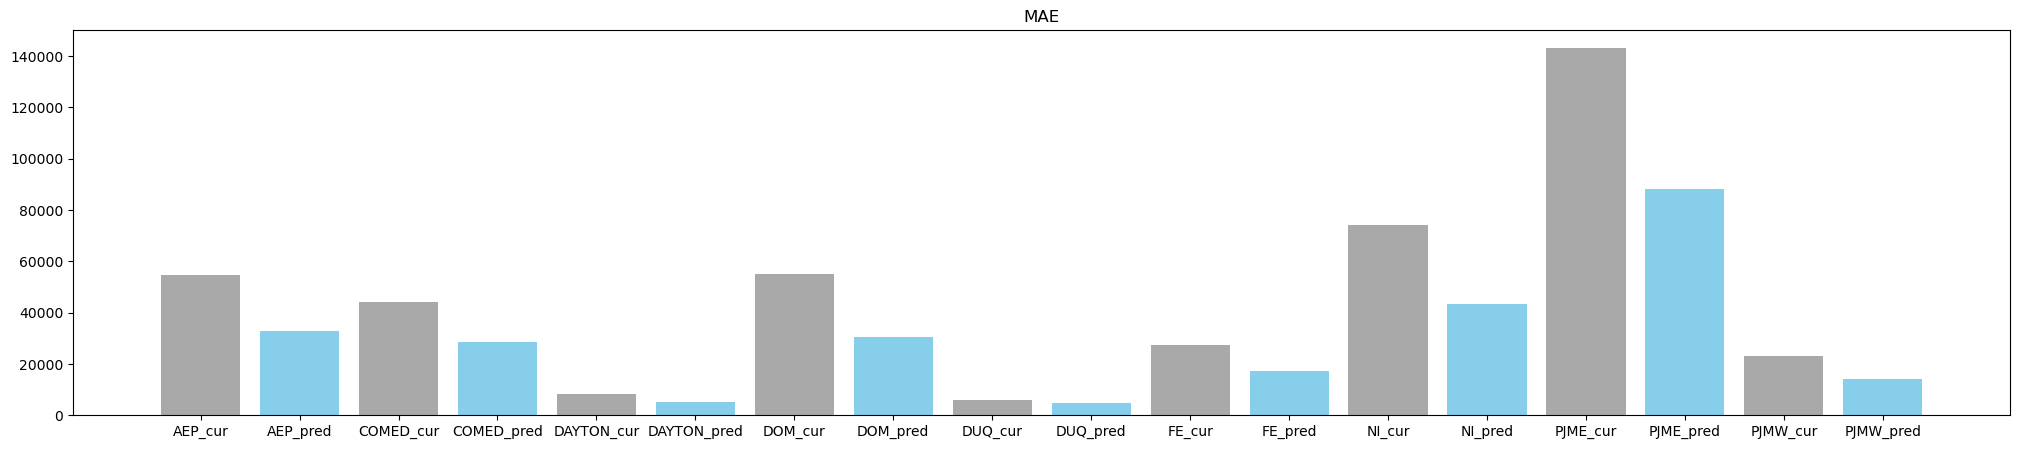

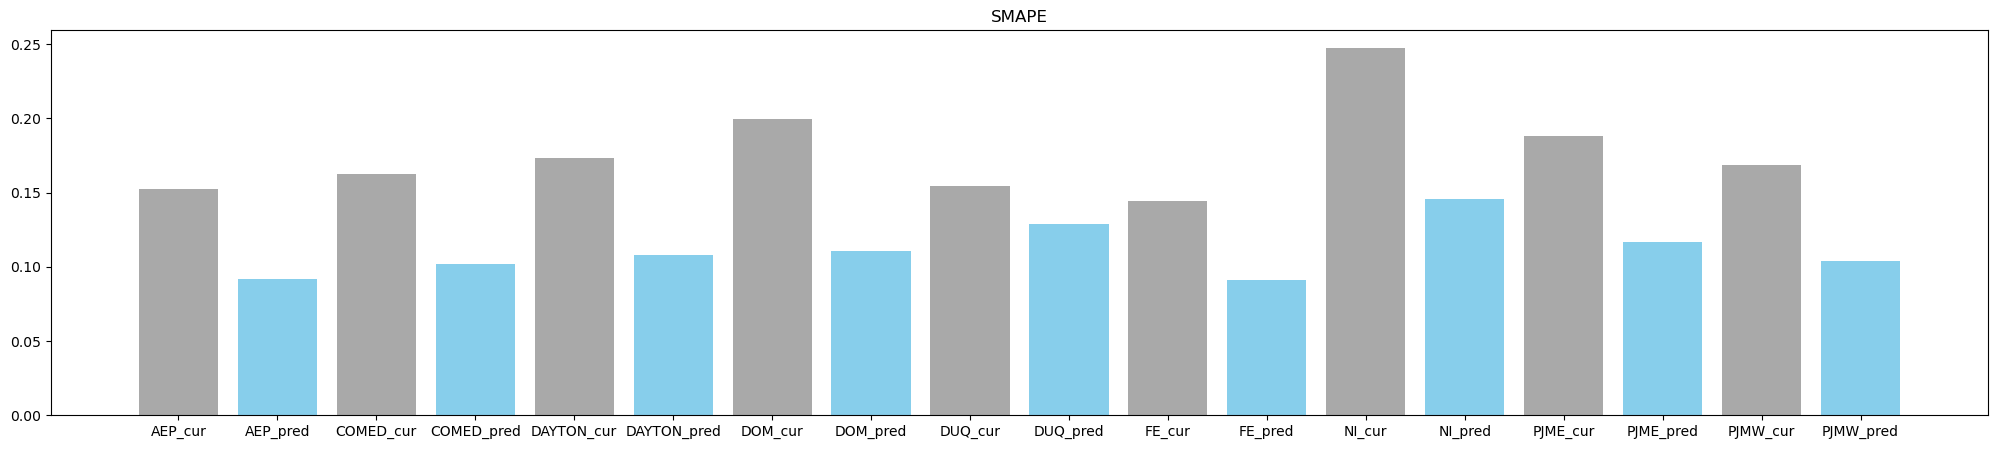

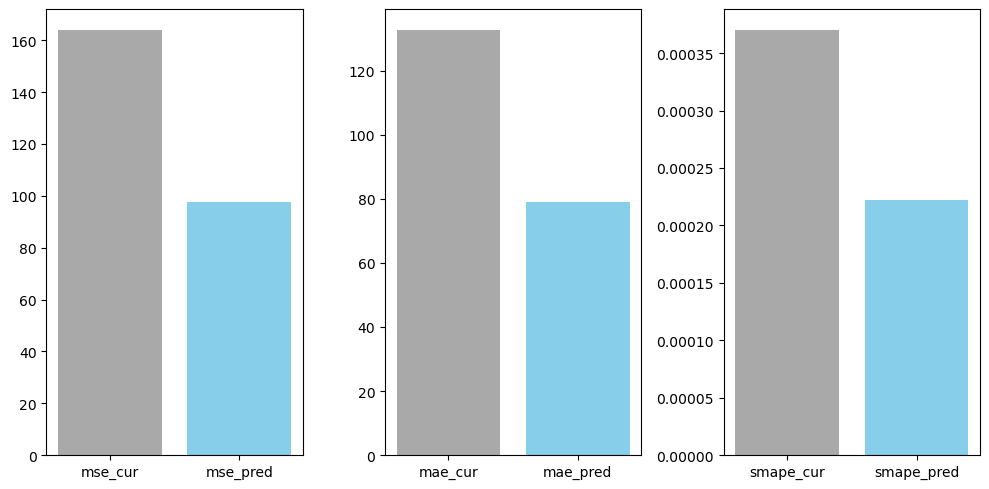

mse : 163.87168884277344 / 97.75581359863281, mae : 132.6172332763672 / 79.05154418945312, smape : 0.0003699068329297006 / 0.00022199959494173527


In [ ]:
import torch.nn as nn
from torchmetrics.regression import SymmetricMeanAbsolutePercentageError as SMAPE

mse = nn.MSELoss()
mae = nn.L1Loss()
smape = SMAPE()

tot_mse_cur = 0
tot_mae_cur = 0
tot_smape_cur = 0

tot_mse_pred = 0
tot_mae_pred = 0
tot_smape_pred = 0

mse_score = []
mae_score = []
smape_score = []

plot_col = 3
sub_num = [len(type_list) // plot_col + 1, plot_col, 1]

plt.figure(figsize=(10, 10))

for t in type_list :
    if DATA_TYPE == 'PMJ_':
        cur, pred, true = torch.Tensor(cur_values['PMJ_' + t]), torch.Tensor(predictions['PMJ_' + t]), torch.Tensor(true_values['PMJ_' + t])
    else:
        cur, pred, true = torch.Tensor(cur_values[t]), torch.Tensor(predictions[t]), torch.Tensor(true_values[t])
    print(t)
    mse_score += [mse(cur, true) ** 0.5, mse(pred, true) ** 0.5]
    mae_score += [mae(cur, true), mae(pred, true)]
    smape_score += [smape(cur, true), smape(pred, true)]
    print(f"mse:{mse(cur, true)}, mae:{mae(cur, true)}, smape:{smape(cur, true)} (cur)")
    print(f"mse:{mse(pred, true)}, mae:{mae(pred, true)}, smape:{smape(pred, true)} (pred)")

    tot_mse_cur += mse_score[0] / len(true)
    tot_mae_cur += mae_score[0] / len(true)
    tot_smape_cur += smape_score[0] / len(true)

    tot_mse_pred += mse_score[1] / len(true)
    tot_mae_pred += mae_score[1] / len(true)
    tot_smape_pred += smape_score[1] / len(true)
    
    sub_num[-1] += 1


colors = ['darkgray', 'skyblue']

# for i in range(len(mse_score)):
#     mse_score[i] = float(mse_score[i].item())
#     mae_score[i] = float(mae_score[i].item())
#     smape_score[i] = float(smape_score[i].item())


x_labels = []
for t in type_list:
    x_labels += [t + '_cur', t + '_pred' ]

plt.figure(figsize=(25, 5))
plt.title('RMSE')
plt.bar(x_labels, mse_score, color=colors * 9)
plt.show()
plt.figure(figsize=(25, 5))
plt.title('MAE')
plt.bar(x_labels, mae_score, color=colors * 9)
plt.show()
plt.figure(figsize=(25, 5))
plt.title('SMAPE')
plt.bar(x_labels, smape_score, color=colors * 9)
plt.show()

tot_mse_cur /= len(type_list)
tot_mae_cur /= len(type_list)
tot_smape_cur /= len(type_list)

tot_mse_pred /= len(type_list)
tot_mae_pred /= len(type_list)
tot_smape_pred /= len(type_list)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.bar(['mse_cur', 'mse_pred'], [tot_mse_cur, tot_mse_pred, ], color=colors)
plt.subplot(1, 3, 2)
plt.bar(['mae_cur', 'mae_pred'], [tot_mae_cur, tot_mae_pred], color=colors)
plt.subplot(1, 3, 3)
plt.bar(['smape_cur', 'smape_pred'], [tot_smape_cur, tot_smape_pred], color=colors)
plt.tight_layout()
plt.show()
print(f'mse : {tot_mse_cur} / {tot_mse_pred}, mae : {tot_mae_cur} / {tot_mae_pred}, smape : {tot_smape_cur} / {tot_smape_pred}')

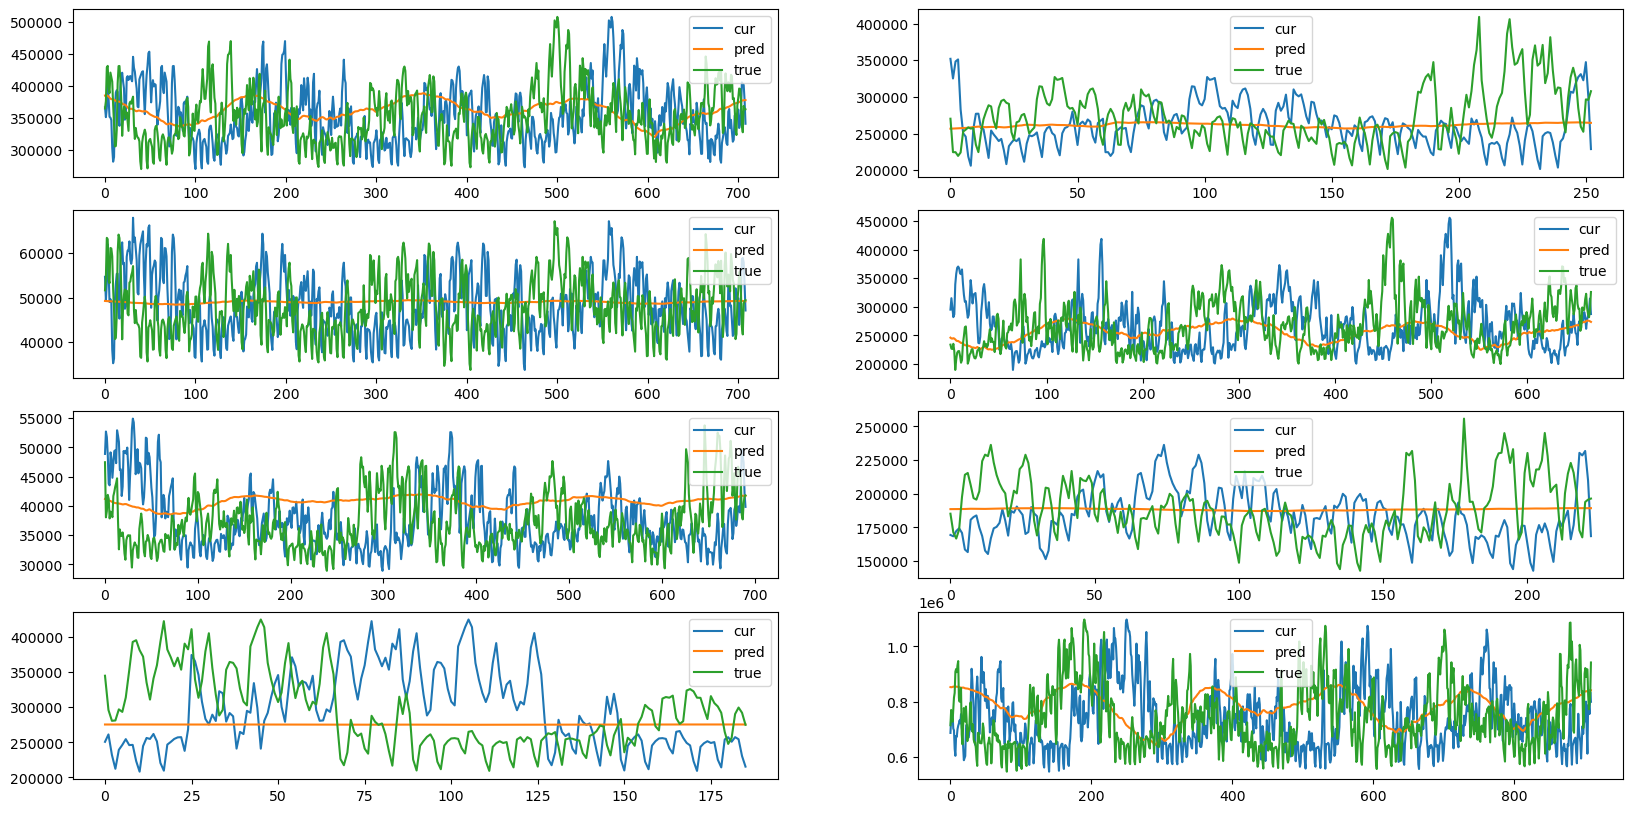

In [ ]:
plot_col = 2
sub_num = [len(type_list) // plot_col, plot_col, 1]
plt.figure(figsize=(20, 10))
for t in type_list[:-1]:
    plt.subplot(*sub_num)
    if DATA_TYPE == 'PMJ_':
        plt.plot(cur_values['PMJ_' + t], label='cur')
        plt.plot(predictions['PMJ_' + t], label='pred')
        plt.plot(true_values['PMJ_' + t], label='true')
    else:
        plt.plot(cur_values[t], label='cur')
        plt.plot(predictions[t], label='pred')
        plt.plot(true_values[t], label='true')
    plt.legend()
    sub_num[-1] += 1
plt.show()